In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,precision_recall_curve, f1_score,make_scorer, fbeta_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
#from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier


In [3]:
df.dtypes

FeatureX                                  int64
FeatureY                                  int64
User_ID                                  object
Countries_ID                             object
Created At time                          object
Created At Year                           int64
Created At Month                          int64
Created At Day_of_month                   int64
creation_date                            object
job_activity_count                        int64
comp_activity_count                       int64
blog_activity_count                       int64
badge_activity_count                      int64
Accepted Team Leadership Transfer       float64
Applied To Job                          float64
Changed Password                        float64
Confirmed Email                         float64
Created Submission                      float64
Created Team                            float64
Deleted Team                            float64
Downloaded Competition Datafile         

In [14]:
df = pd.read_csv("data/data.csv")
df = df.drop(index = df.loc[(df['Created At Month'] == 5) | (df['Created At Month'] == 10)].index)
X = df.select_dtypes(include=["number"]).drop(columns=["target"])

y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    min_samples_leaf=4,
    random_state=42,
    class_weight='balanced'
)


In [16]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model, beta=1):
    """
    Trains the model, evaluates default and optimal threshold, and plots results.
    """
    model.fit(X_train, y_train)
    print("Model training complete.")

    y_pred_default = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred_default, target_names=['No Fraud (0)', 'Fraud (1)']))
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"The ROC AUC score is: {auc:.4f}")

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ROC Curve
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, marker='.', label='ROC Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Find optimal threshold using F2-score
    f2_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-9)

    optimal_idx = np.argmax(f2_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    print(f"\nOptimal threshold found: {optimal_threshold:.4f}")
    print(f"This threshold gives a Precision of {precision[optimal_idx]:.4f} and a Recall of {recall[optimal_idx]:.4f}")

    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    print(classification_report(y_test, y_pred_optimal, target_names=['No Fraud (0)', 'Fraud (1)']))
    f2 = fbeta_score(y_test, y_pred_optimal, beta=2)
    print(f"F2 Score: {f2:.4f}")
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted No Fraud', 'Predicted Fraud'],
                yticklabels=['Actual No Fraud', 'Actual Fraud'])
    plt.title('Confusion Matrix with Optimal Threshold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Model training complete.
              precision    recall  f1-score   support

No Fraud (0)       0.97      0.85      0.91      1568
   Fraud (1)       0.24      0.62      0.35       118

    accuracy                           0.84      1686
   macro avg       0.60      0.74      0.63      1686
weighted avg       0.92      0.84      0.87      1686

The ROC AUC score is: 0.8210


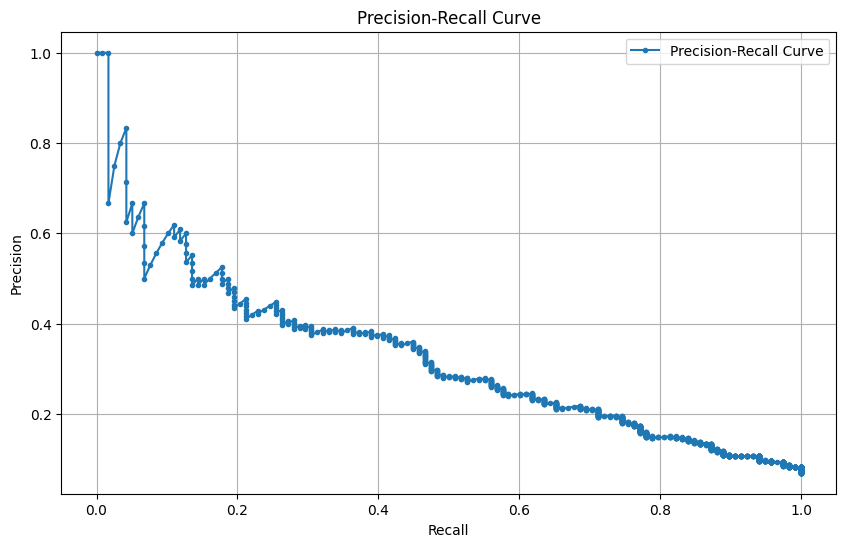

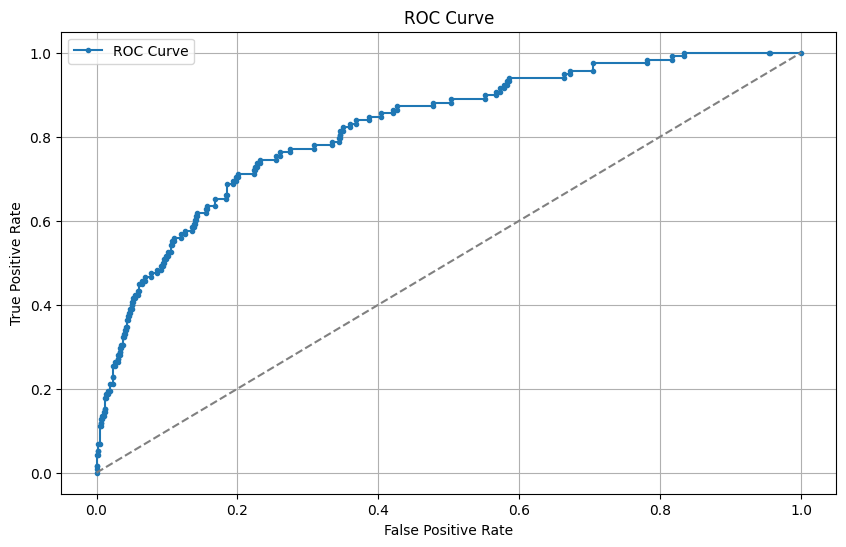


Optimal threshold found: 0.5999
This threshold gives a Precision of 0.3605 and a Recall of 0.4492
              precision    recall  f1-score   support

No Fraud (0)       0.96      0.94      0.95      1568
   Fraud (1)       0.36      0.45      0.40       118

    accuracy                           0.91      1686
   macro avg       0.66      0.69      0.67      1686
weighted avg       0.92      0.91      0.91      1686

F2 Score: 0.4281


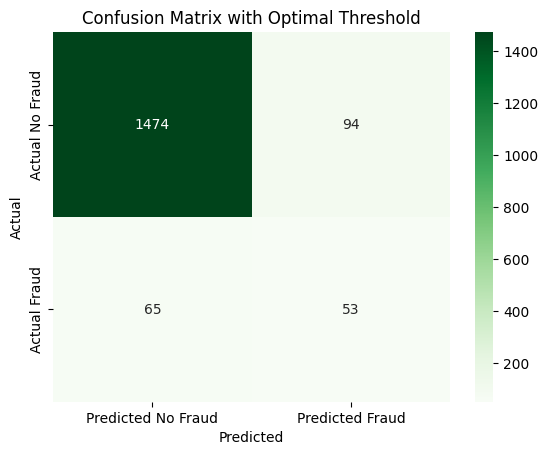

In [17]:
X_train_scaled
train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, clf)

In [18]:
def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plots the top_n most significant features based on feature importance from a fitted model.
    Args:
        model: Trained tree-based model with feature_importances_ attribute.
        feature_names: List of feature names.
        top_n: Number of top features to display.
    """
    importances = model.feature_importances_
    feat_imp = pd.Series(importances, index=feature_names)
    top_features = feat_imp.sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(8, 6))
    top_features.plot(kind='barh')
    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print(top_features)

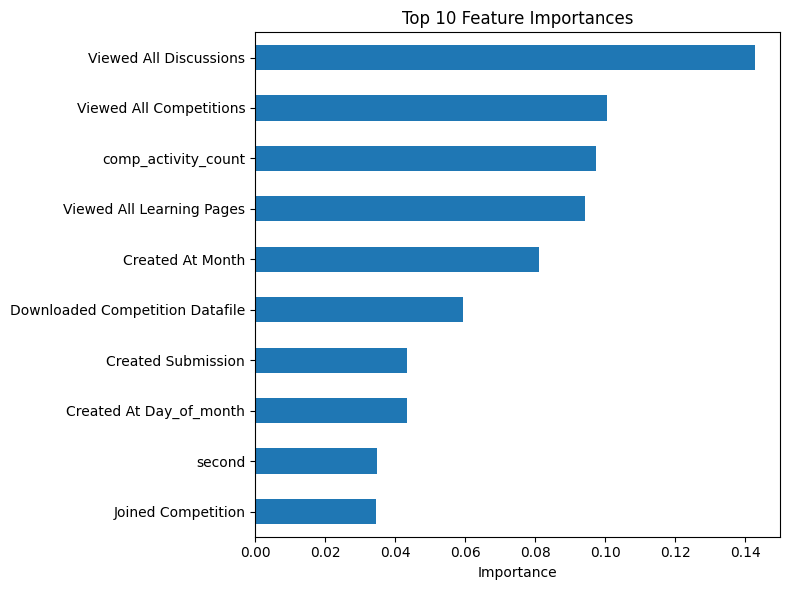

Viewed All Discussions             0.142733
Viewed All Competitions            0.100447
comp_activity_count                0.097275
Viewed All Learning Pages          0.094318
Created At Month                   0.081010
Downloaded Competition Datafile    0.059253
Created Submission                 0.043313
Created At Day_of_month            0.043292
second                             0.034866
Joined Competition                 0.034546
dtype: float64


In [19]:
plot_feature_importance(clf, X.columns, top_n=10)

In [10]:
X.columns

Index(['FeatureX', 'FeatureY', 'Created At Year', 'Created At Month',
       'Created At Day_of_month', 'job_activity_count', 'comp_activity_count',
       'blog_activity_count', 'badge_activity_count',
       'Accepted Team Leadership Transfer', 'Applied To Job',
       'Changed Password', 'Confirmed Email', 'Created Submission',
       'Created Team', 'Deleted Team', 'Downloaded Competition Datafile',
       'Invited Member To Team', 'Joined Competition', 'Joined Team',
       'Kicked Member From Team', 'Left Team', 'Report Something',
       'Revoked Team Leadership Transfer', 'Signed In', 'Signed Out',
       'Transferred Team Leadership', 'Updated Comment', 'Updated Discussion',
       'Updated Discussion Team Participants', 'Updated Profile',
       'Updated Submission', 'Updated Team', 'Viewed All Competitions',
       'Viewed All Discussions', 'Viewed All Jobs',
       'Viewed All Learning Pages', 'Viewed Discussion', 'Viewed FAQ',
       'Votes (Up/Down)', 'competitons_count',

In [20]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
xgb = XGBClassifier(
    n_estimators=500,        # trees, tune with early stopping
    learning_rate=0.05,      # conservative, allows more trees
    max_depth=6,             # controls complexity
    min_child_weight=1,      # larger -> more conservative splits
    subsample=0.8,           # row sampling
    colsample_bytree=0.8,    # feature sampling
    reg_lambda=1,            # L2 regularization
    reg_alpha=0,             # L1 regularization
    scale_pos_weight=scale_pos_weight,      # adjust if imbalance exists (see below)
    objective="binary:logistic",
    eval_metric="logloss",   # use logloss during training
    random_state=42,
    n_jobs=-1,
    
)


Model training complete.
              precision    recall  f1-score   support

No Fraud (0)       0.94      0.97      0.96      1568
   Fraud (1)       0.35      0.23      0.28       118

    accuracy                           0.92      1686
   macro avg       0.65      0.60      0.62      1686
weighted avg       0.90      0.92      0.91      1686

The ROC AUC score is: 0.7986


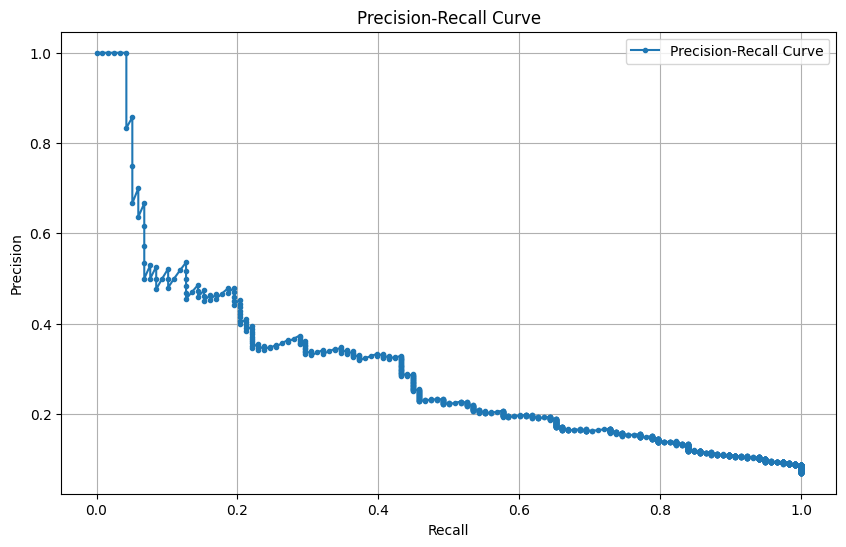

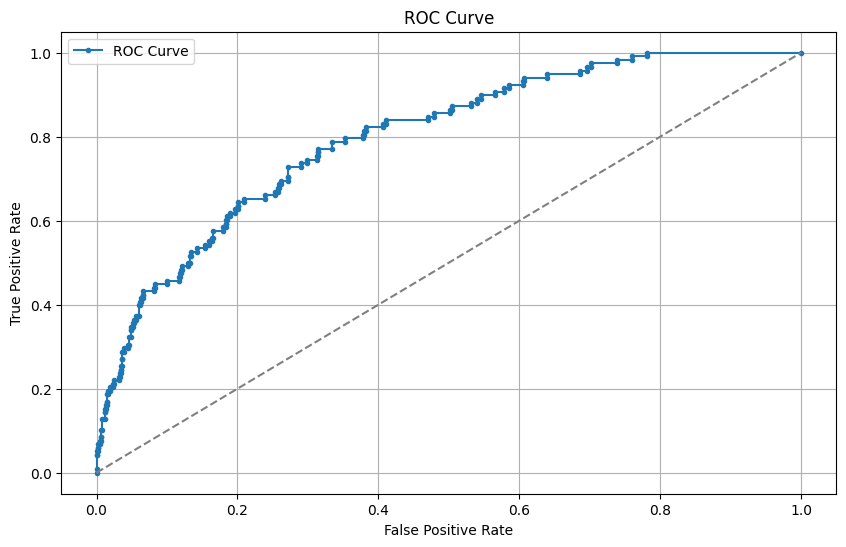


Optimal threshold found: 0.3401
This threshold gives a Precision of 0.3290 and a Recall of 0.4322
              precision    recall  f1-score   support

No Fraud (0)       0.96      0.93      0.94      1568
   Fraud (1)       0.33      0.43      0.37       118

    accuracy                           0.90      1686
   macro avg       0.64      0.68      0.66      1686
weighted avg       0.91      0.90      0.90      1686

F2 Score: 0.4067


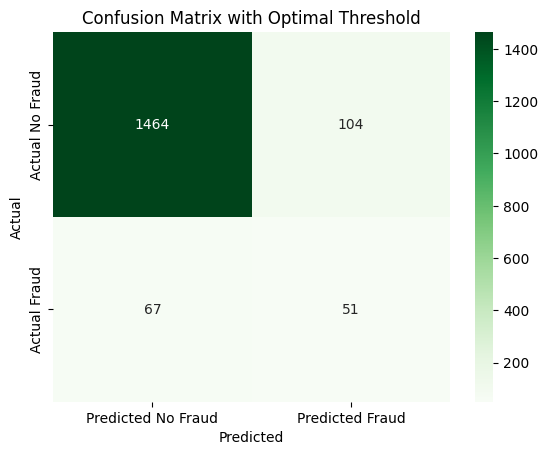

In [21]:

train_and_evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, xgb)

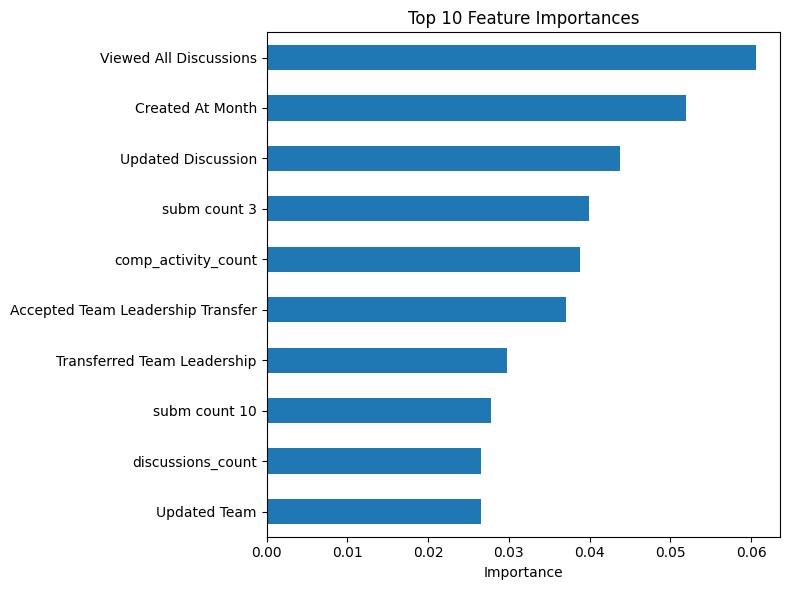

Viewed All Discussions               0.060564
Created At Month                     0.051925
Updated Discussion                   0.043745
subm count 3                         0.039942
comp_activity_count                  0.038782
Accepted Team Leadership Transfer    0.037044
Transferred Team Leadership          0.029728
subm count 10                        0.027780
discussions_count                    0.026569
Updated Team                         0.026544
dtype: float32


In [22]:
plot_feature_importance(xgb, X.columns, top_n=10)